In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
from scipy import stats
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 7.86
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 7.86)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((7.86 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[4:117].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        SMPS[key][bin] = pd.to_numeric(SMPS[key][bin]) * bin_width

[ 0.486968  0.523492  0.5625    0.6045    0.6495    0.698     0.75
  0.806     0.8665    0.9315    1.001     1.0755    1.1555    1.2415
  1.334     1.434     1.541     1.6555    1.779     1.912     2.055
  2.2085    2.373     2.55      2.7405    2.945     3.1645    3.4005
  3.6545    3.927     4.2195    4.5345    4.873     5.2365    5.627
  6.0465    6.498     6.983     7.504     8.064     8.6655    9.312
 10.0085   10.755    11.555    12.415    13.34     14.34     15.41
 16.555    17.79     19.12     20.53    ]


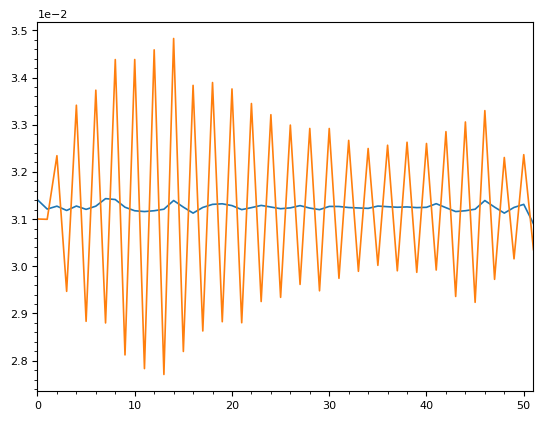

In [4]:
APS_bin_mean1 = [np.sqrt(0.486968 * 0.523)]
APS_bin_mean2 = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean1.append(float(key))
    APS_bin_mean2.append(float(key))
APS_cut_point1 = bin_edges(0.486968, APS_bin_mean1)
APS_cut_point2 = np.concatenate(([0.486968], (np.array(APS_bin_mean2)[1:]+np.array(APS_bin_mean2)[:-1])/2, [20.53]))
print(APS_cut_point)
# plt.plot()
# plt.plot(APS_cut_point1- APS_cut_point2)
plt.plot(np.log10(APS_cut_point2[1:])- np.log10(APS_cut_point2[:-1]))
plt.plot(np.log10(np.array(APS_cut_point1)[1:])-np.log10(np.array(APS_cut_point1)[:-1]))

In [4]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

ax_labels = ['Particle diameter / $\mu$m', 'dN / #/cm$^{3}$', 'dM / $\mu$g/m$^{3}$']

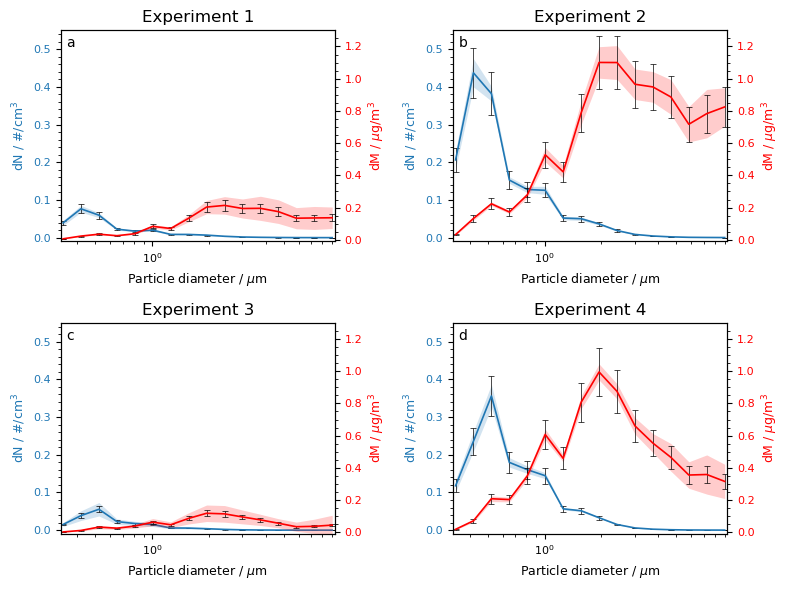

In [5]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

OPS_mass_conc = {}
for key in OPS_dict_keys:
    mass_conc = calc_mass_conc(OPS_APS[key], OPS_bins, OPS_mid_point, 7.86)
    OPS_mass_conc[key] = mass_conc

OPS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], OPS_APS[key], OPS_mass_conc[key], OPS_bins, 'Time', OPS_mid_point, ['tab:blue', 'red'], 0.15, ax_labels, True, None)
    OPS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': np.array(OPS_mid_point), 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_xlim(min(OPS_mid_point) - 0.01, max(OPS_mid_point) + 0.3)
    ax.set_ylim(-0.01, 0.55)
    ax2.set_ylim(-0.01, 1.3)
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/OPS_mean.png', dpi = 600)

In [89]:
def detect_shoulders(x, y, threshold=0.1):
    """Detect shoulders based on the second derivative (curvature)."""
    
    # Calculate first and second derivatives
    dy = np.diff(y)  # First derivative (slope)
    d2y = np.diff(dy)  # Second derivative (curvature)

    # Initialize shoulder regions
    shoulders = []
    
    # Iterate through the data to find shoulder-like features
    for i in range(1, len(d2y) - 1):
        # Look for inflection points where the second derivative changes sign
        if d2y[i - 1] > 0 and d2y[i] < 0:  # Peak of curvature (turning from up to down)
            # Check if the slope is gradually changing (shoulder)
            if abs(dy[i]) < threshold:
                # Record the start and end of the shoulder region
                shoulder_start = x[i - 1]
                shoulder_end = x[i + 1]
                shoulders.append((shoulder_start, shoulder_end))
    
    return shoulders

def find_gauss_peaks(x, y, sy):
    x, y, sy = np.array(x), np.array(y), np.array(sy)

    Npoints = len(y)

    # Step 1: Detect peaks
    peaks, _ = find_peaks(y)    # , prominence=1e-2, height=1e-3)
    if len(peaks) == 0:
        print("No peaks detected. Adjust parameters.")
        return np.zeros_like(x), [], [], [], []  # Return empty results if no peaks

    mu_guess_peaks = x[peaks]
    A_guess_peaks = y[peaks]
    sigma_guess_peaks = [0.1] * len(peaks)  # Uniform width guess for peaks

    # Step 2: Detect shoulders using second derivative
    shoulders = detect_shoulders(x, y)

    # Step 3: Define fitting function for a single Gaussian
    def single_gaussian(x, sigma, mu, A):
        return A * np.exp(-0.5 * ((x - mu) / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

    # Step 4: Fit each peak and shoulder separately
    def fit_single_peak(x, y, sy, initial_guess):
        def chi2_single(*params):
            y_fit = single_gaussian(x, *params)
            chi2 = np.sum(((y - y_fit) / sy)**2)  # Chi-squared calculation
            return chi2

        try:
            minuit_chi2 = Minuit(chi2_single, *initial_guess)
            minuit_chi2.limits = [(1e-3, None)] * len(initial_guess)  # Ensure no parameters are zero
            minuit_chi2.migrad()  # Perform the minimization
        except Exception as e:
            print(f"Fitting failed: {e}")
            return None

        fitted_params = minuit_chi2.values
        errors = minuit_chi2.errors
        return fitted_params, errors

    peak_results = []
    shoulder_results = []
    df = pd.DataFrame({'x fit': np.linspace(min(x), max(x), 1000)})
    
    for i in range(len(peaks)):
        peak_initial_guess = [sigma_guess_peaks[i], mu_guess_peaks[i], A_guess_peaks[i]]
        peak_fitted_params, peak_errors = fit_single_peak(x[peaks[i]-10:peaks[i]+10], y[peaks[i]-10:peaks[i]+10], sy[peaks[i]-10:peaks[i]+10], peak_initial_guess)
        df['Peak ' + str(i + 1)] = single_gaussian(df['x fit'], *peak_fitted_params)
        if peak_fitted_params is not None:
            peak_results.append(peak_fitted_params)

    for shoulder in shoulders:
        shoulder_mu = np.mean(shoulder)  # Take the average of the shoulder
        mu_guess_peaks = np.concatenate((mu_guess_peaks, [shoulder_mu]))

        shoulder_center_idx = np.argmin(np.abs(x - shoulder_mu))  # Find the closest index to the shoulder's center
        shoulder_A = y[shoulder_center_idx]  # Amplitude of the shoulder
        A_guess_peaks = np.concatenate((A_guess_peaks, [shoulder_A]))
        shoulder_sigma = (shoulder[1] - shoulder[0]) / 3  # Estimate sigma based on the shoulder width

        # Convert shoulder[0] and shoulder[1] to integers
        start_idx = int(shoulder[0])  # Ensure start index is an integer
        end_idx = int(shoulder[1])    # Ensure end index is an integer

        shoulder_initial_guess = [shoulder_sigma, shoulder_mu, shoulder_A]
        shoulder_fitted_params, shoulder_errors = fit_single_peak(x[start_idx:end_idx], y[start_idx:end_idx], sy[start_idx:end_idx], shoulder_initial_guess)
        df['Shoulder ' + str(i + 1)] = single_gaussian(df['x fit'], *shoulder_fitted_params)
        
        if shoulder_fitted_params is not None:
            shoulder_results.append(shoulder_fitted_params)

    # Combine results into one output
    fitted_params_all = []
    errors_all = []
    for peak_result in peak_results:
        if peak_result is not None:
            fitted_params_all.append(peak_result[0])
            errors_all.append(peak_result[1])
    for shoulder_result in shoulder_results:
        if shoulder_result is not None:
            fitted_params_all.append(shoulder_result[0])
            errors_all.append(shoulder_result[1])

    # Step 7: Calculate chi-squared value and probability for the combined fits
    Nvar = len(fitted_params_all) * 3  # Each peak and shoulder has 3 parameters
    Ndof_fit = Npoints - Nvar
    chi2_value = sum([result[0] for result in peak_results])  # Sum chi2 for individual fits
    Prob_value = stats.chi2.sf(chi2_value, Ndof_fit)

    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_fit:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

    return df, mu_guess_peaks, A_guess_peaks, fitted_params_all, errors_all

def plot_gauss_fit(ax, x, y, sy, datatype):

    df, peak_positions, peak_heights, fitted_params, errors = find_gauss_peaks(x, y, sy)
    
    n_lines = len(df.keys()) - 1
    cmap = mpl.colormaps['cool']
    colors = cmap(np.linspace(0, 1, n_lines))

    # Plot data and fit
    # ax.plot(x, y, label="Data")
    ax.errorbar(x, y, sy, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, label = 'Data', color = 'tab:blue')
    
    for key, clr in zip(df.keys()[1:], colors):
        ax.plot(df['x fit'],  df[key], label=key + " fit", linestyle="--", color = clr, zorder = -10)
    ax.scatter(peak_positions, peak_heights, color="red", label="Detected Peaks", marker = 'x', zorder = 10)
    ax.legend(fontsize = 8)
    ax.set(xscale='log', xlabel='Particle diameter / $\mu$m')
    if datatype == 'number':
        ax.set_ylabel('dN / #/cm$^{3}$')
    if datatype == 'mass':
        ax.set_ylabel('dM / $\mu$/m$^{3}$')

    return ax, df

Chi2 value: 0.2   Ndof = 4    Prob(Chi2,Ndof) = 0.995
Chi2 value: 0.1   Ndof = 7    Prob(Chi2,Ndof) = 1.000
Chi2 value: 0.1   Ndof = 7    Prob(Chi2,Ndof) = 1.000
Chi2 value: 0.1   Ndof = 7    Prob(Chi2,Ndof) = 1.000


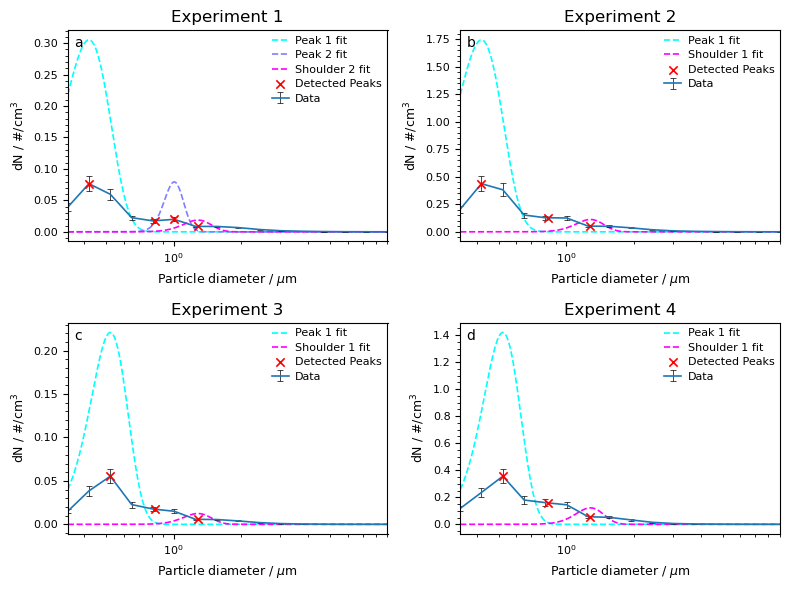

In [90]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]
    
    df = OPS_mean_conc[key]
    ax, y_fit = plot_gauss_fit(ax, df['Diameter'], df['number'], df['error number'], 'number')

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Gaussian_fits/OPS_fitted_number.png', dpi = 600)

Initial guess (length: 21): [0.1, 0.522, 0.0349196411777565, 0.1, 1.007, 0.08356975788417216, 0.1, 2.421, 0.21359993001547056, 0.1, 3.752, 0.19542743340580992, 0.11899999999999995, 0.8285, 0.03786311239631991, 0.22999999999999998, 1.599, 0.13374494243117152, 0.44366666666666665, 3.0865, 0.19435403704045526]
Chi2 value: 11.8   Ndof = -5    Prob(Chi2,Ndof) =   nan
Initial guess (length: 12): [0.1, 0.522, 0.2235636904780699, 0.1, 1.007, 0.5277988492971791, 0.1, 1.944, 1.100690044565174, 0.44366666666666665, 3.0865, 0.9654657987911937]
Chi2 value: 39.2   Ndof = 4    Prob(Chi2,Ndof) = 0.000
Initial guess (length: 21): [0.1, 0.522, 0.032431501065120084, 0.1, 1.007, 0.06316087278768501, 0.1, 1.944, 0.118173763786978, 0.06166666666666667, 0.4295, 0.011647336661997623, 0.11899999999999995, 0.8285, 0.03841061099765696, 0.18500000000000005, 1.2845, 0.046810572372594735, 0.44366666666666665, 3.0865, 0.09531304541443177]
Chi2 value: 0.6   Ndof = -5    Prob(Chi2,Ndof) =   nan
Initial guess (length: 

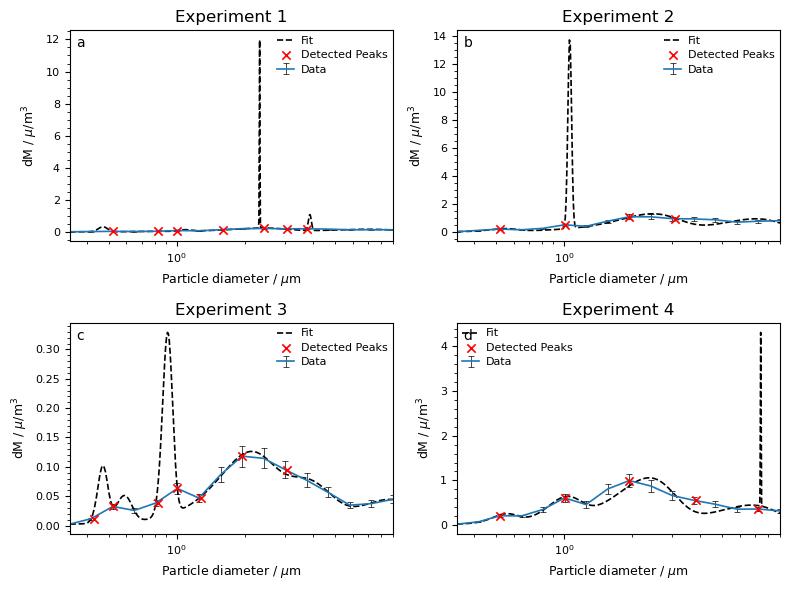

In [66]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]
    
    df = OPS_mean_conc[key]
    ax, y_fit = plot_gauss_fit(ax, df['Diameter'], df['mass'], df['error mass'], 'mass')

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Gaussian_fits/OPS_fitted_mass.png', dpi = 600)

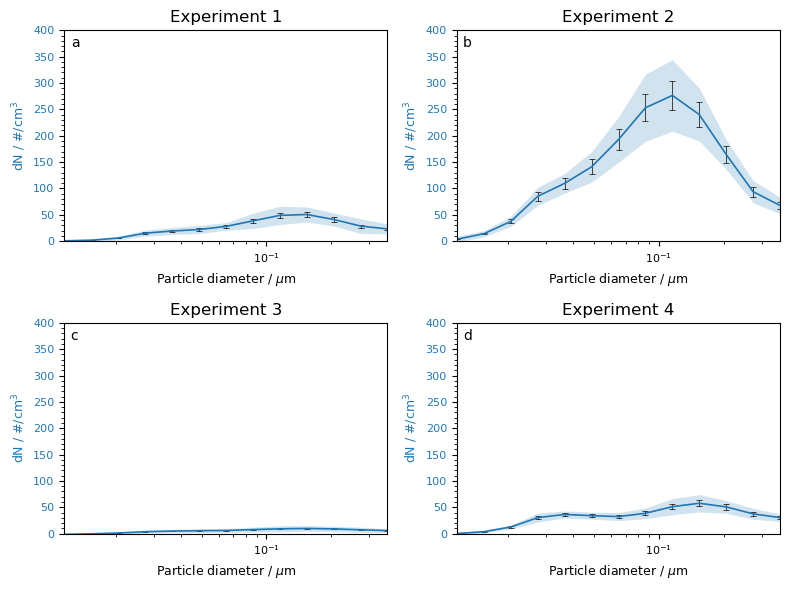

In [ ]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key) / 1000)
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()

NS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(NanoScan_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS[key], None, NanoScan_Bins, 'Time', NanoScan_bin_mean, ['tab:blue'], 0.10, ax_labels, False, None)
    NS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': NanoScan_bin_mean, 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_ylim(-0.5, 400)

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/NanoScan_mean.png', dpi = 600)

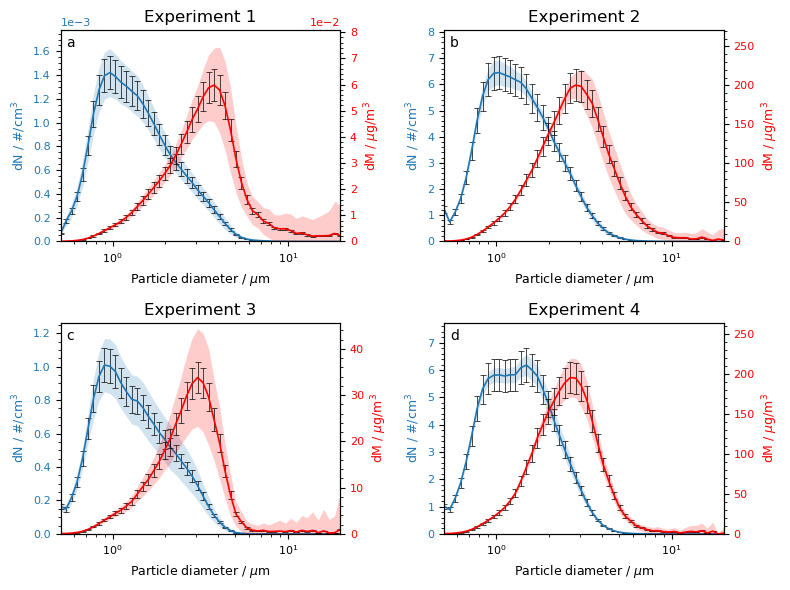

In [ ]:
APS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(APS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], OPS_APS[key], APS_mass_conc[key], APS_bins, 'Time', APS_bin_mean, ['tab:blue', 'red'], 0.10, ax_labels, True, None)
    APS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': APS_bin_mean, 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_ylim(0, max(number) + 0.25 * max(number))
    ax2.set_ylim(0, max(mass) + 0.35 * max(mass))

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/APS_mean.png', dpi = 600)

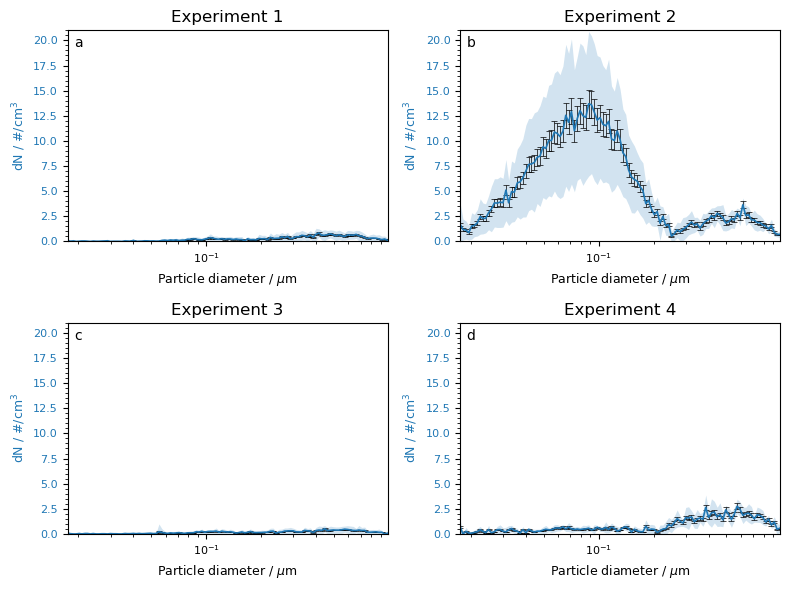

In [ ]:
SMPS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(SMPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS[key], None, SMPS_bins, 'Time', SMPS_bin_mean, ['tab:blue'], 0.10, ax_labels, False, None)
    SMPS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': SMPS_bin_mean, 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_ylim(0, 21)

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)
    
sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_mean.png', dpi = 600)